In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os

#plots.py
# . . .
def plot_lines(df, linewidth = 1, figsize = (40,20),
               secondary_y = None, legend=True,
               h_zero = True, pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna().plot.line(linewidth = linewidth, ax = ax, secondary_y=secondary_y, legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x,2) for x in vals]) 
    if h_zero: ax.axhline(0, ls="--", color = "k")
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def corr_matrix_heatmap(df, save_fig = False, pp = None):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(df, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = df.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(df.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " corrMatrix.png",
            bbox_inches = "tight")

        if pp != None: pp.savefig(fig, bbox_inches="tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, 
                       figsize = (40, 20),
                       pp = None, total_var = False,
                      title = False):
    fig, ax = plt.subplots(figsize = figsize)
    # df.plot.area() created a stacked plot
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax,
                                c = "k",label = total_var, 
                                ls = "--")
    # place legend in top left corner of plot
    # format legend so that there are two columns of names
    ax.legend(loc = 2, ncol = 2)
    if title != False:
        plt.title(title)
        
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [2]:

data_dict = {"$CPI$":"CPIAUCNS",             
             "$PCE_{Headline}$": "PCEPI",
             "10 Year UST": "DGS10",
             "Effective Federal Funds Rate (%)": "DFF",    
             "Industrial Production Index":"INDPRO",
             "Currency in Circulation":"CURRCIR",
            "Unemployment Rate":"UNRATE",
            "Natural Rate of Unemployment": "NROU"}
freq = "M"
start = datetime.datetime(1950, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

data = gather_data(data_dict, start, 
          end = end, freq = freq)
data["Natural Rate of Unemployment"]= data["Natural Rate of Unemployment"].interpolate(option="linear")


In [3]:
keys = data.keys()
annual_rate = data.copy()
monthly_rate = data.copy()
for key in keys:
#     if "PPI" in key or "CPI" in key or "M2" in key:
    annual_rate[key] = data[key].pct_change(12) * 100
    monthly_rate[key] = ((data[key].pct_change(1)).add(1)).pow(12).sub(1).mul(100)

for key in keys:
    if "Rate" in key or "UST" in key:
        annual_rate[key] = data[key]
        monthly_rate[key] = data[key]
        
diff_annual_rate = annual_rate.diff(12)

In [4]:
inflation_target = 2
for df in [annual_rate, monthly_rate]:
    df["Inflation Loss"]= df["$PCE_{Headline}$"].sub(inflation_target)
    df["Unemployment Loss"]= df["Unemployment Rate"].sub(data["Natural Rate of Unemployment"])
    df["Inflation Loss Sq"]= df["Inflation Loss"].pow(2)
    df["Inflation Loss Sq"][df["Inflation Loss"] < 0] = df["Inflation Loss Sq"][df["Inflation Loss"] < 0].mul(-1) 
    df["Inflation Loss"] = df["Inflation Loss Sq"]
    df["Unemployment Loss Sq"]= df["Unemployment Loss"].pow(2)
    df["Unemployment Loss Sq"][df["Unemployment Loss"] < 0] = df["Unemployment Loss Sq"][df["Unemployment Loss"] < 0].mul(-1)
    df["Unemployment Loss"] = df["Unemployment Loss Sq"]
    df["Loss Function"] = df["Inflation Loss Sq"].sub(df["Unemployment Loss Sq"])
    print(df)

               $CPI$  $PCE_{Headline}$  10 Year UST  \
DATE                                                  
1950-01-31       NaN               NaN          NaN   
1950-02-28       NaN               NaN          NaN   
1950-03-31       NaN               NaN          NaN   
1950-04-30       NaN               NaN          NaN   
1950-05-31       NaN               NaN          NaN   
...              ...               ...          ...   
2022-03-31  8.542456          6.638595     2.127826   
2022-04-30  8.258629          6.269216     2.747500   
2022-05-31  8.581512          6.324989     2.898095   
2022-06-30  9.059758          6.758935     3.143333   
2022-07-31  8.524815          6.335943     2.896000   

            Effective Federal Funds Rate (%)  Industrial Production Index  \
DATE                                                                        
1950-01-31                               NaN                          NaN   
1950-02-28                               NaN         

C:\ProgramData\Anaconda3\envs\rpython\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\ProgramData\Anaconda3\envs\rpython\lib\site-packages\ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator


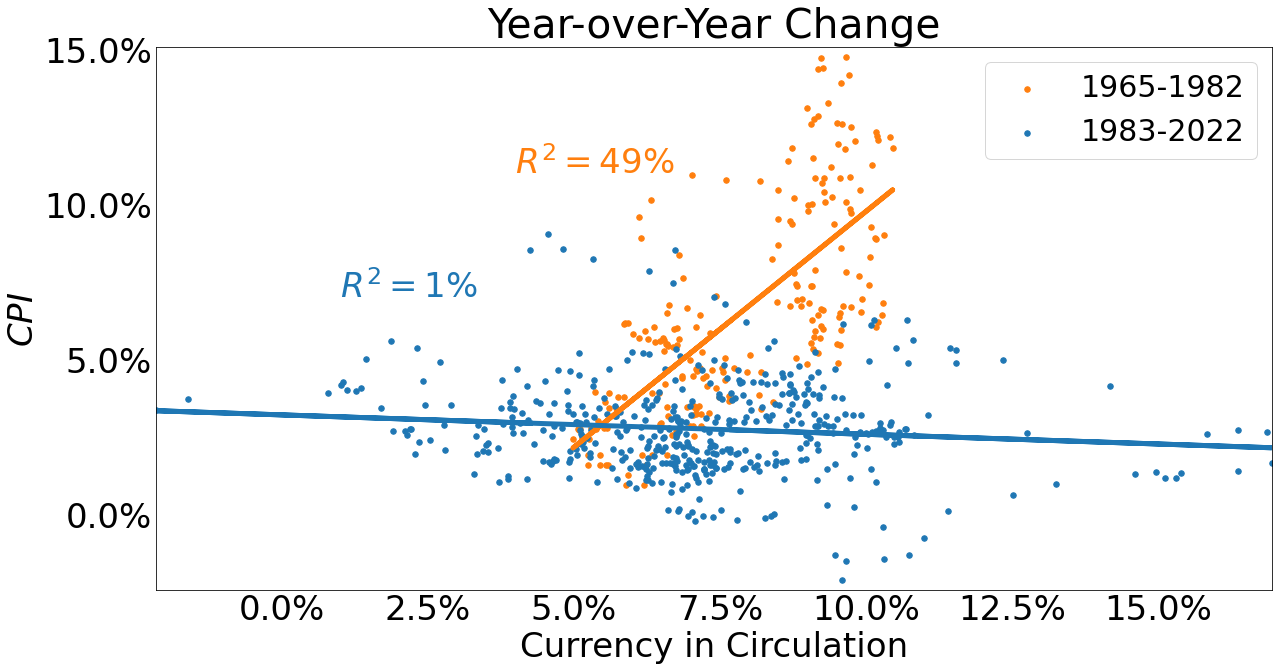

In [5]:
import statsmodels.api as sm
plt.rcParams['axes.ymargin'] = 0.02
plt.rcParams['axes.xmargin'] = 0.00

plt.rcParams.update({'font.size': 34})
fig,ax = plt.subplots(figsize=(20,10))
plot_vars = ["$CPI$", "Currency in Circulation"]   
dates = [1964, 1982, 2022]#, "2022"]
for i in range(len(dates) - 1):
    start = str(dates[i] +1)
    end = str(dates[i + 1])
    annual_rate[plot_vars].loc[start:end].plot.scatter(x = plot_vars[1], y = plot_vars[0],
                                  ax = ax, color = "C" + str(len(dates) - 2  - i), alpha = 1, 
                                                       label = start + "-" + end, s = 30)
    
for i in range(len(dates) - 1):
    start = str(dates[i] +1)
    end = str(dates[i + 1])
    
    y = annual_rate[[plot_vars[0]]].loc[start:end]
    X = annual_rate[[plot_vars[1]]].loc[start:end]
    X["Constant"] = 1
    reg = sm.OLS(y, X)
    results = reg.fit()
    # plot_df["Trend"] = 
    X_new = annual_rate[[plot_vars[1]]].loc[start:end]

    X_new["Intercept"] = 1
    X_new["Trend"] = results.predict(X_new)
    # = results.fittedvalues
    ax.plot(X_new[plot_vars[1]], X_new["Trend"], linewidth = 5, 
                        color = "C" + str(len(dates) - 2  - i))
    ax.text(4 - i * 3,  11 - i * 4, "$R^2=$" + str(int(round(results.rsquared*100,0))) + "%", color = "C" + str(len(dates) - 2  - i))
ax.set_xticklabels([str(x) + "%" for x in ax.get_xticks()])
ax.set_yticklabels([str(y) + "%" for y in ax.get_yticks()])

ax.tick_params('both', length=0, which='both')
ax.set_title("Year-over-Year Change")

plt.legend(fontsize = 30)


# df.keys()

C:\ProgramData\Anaconda3\envs\rpython\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0.5, 1.0, 'Year-over-Year Change')

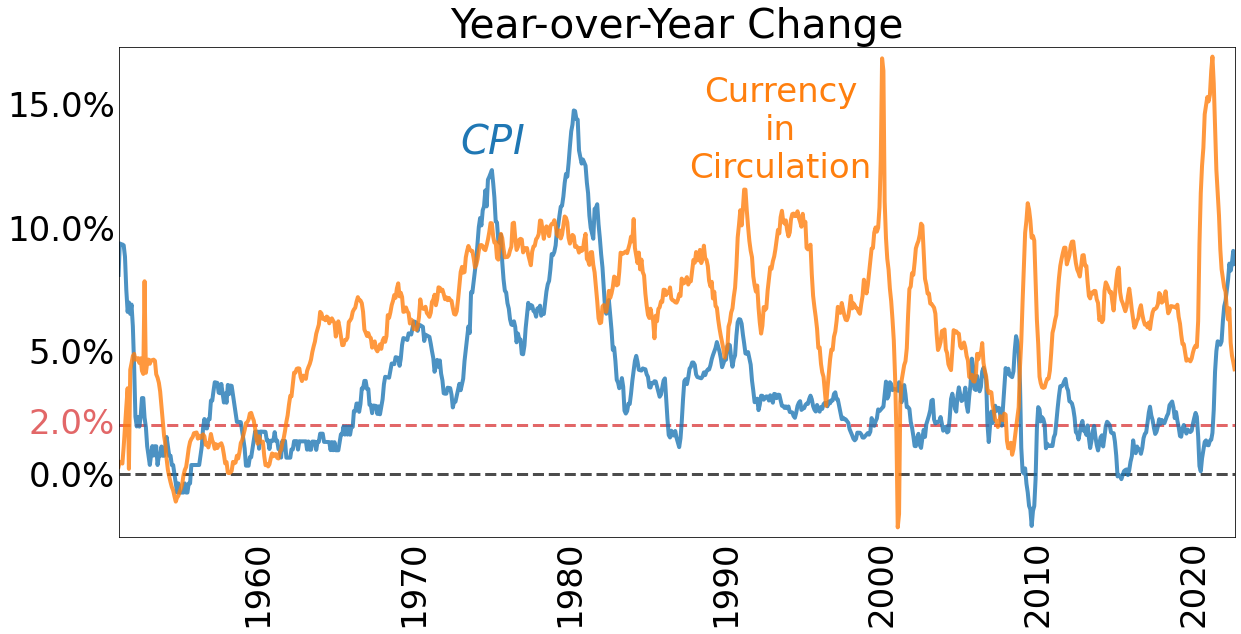

In [30]:
plt.rcParams['axes.ymargin'] = 0.02
plt.rcParams['axes.xmargin'] = 0.00

plt.rcParams.update({'font.size': 34})
plot_vars = ["$CPI$", "Currency in Circulation"]   
plot_df = annual_rate[plot_vars]#.dropna()
fig,ax = plt.subplots(figsize=(20,10))
ax.axhline(0, ls = "--", linewidth = 3, color = "k", alpha = .7)
ax.axhline(2, ls = "--", linewidth = 3, color = "C3", alpha = .7)
plot_df.plot(ax = ax, linewidth = 4, legend = False, alpha = .8)
plot_df.loc["1983":].corr()
plt.xticks(rotation = 90, ha = "center")
ax.text(list(plot_df.index)[9],2,"2.0%", va = "center", color = "C3", ha = "right", alpha = .7)
ax.set_yticklabels([str(y) + "%" for y in ax.get_yticks()])
ax.set_xlabel("")
ax.text("1993-07", 12, plot_vars[1].replace(" ","\n"), ha = "center", color = "C1")
ax.text("1975", 13, plot_vars[0].replace(" ","\n"), ha = "center", color = "C0", fontsize = 40)
ax.tick_params('both', length=0, which='both')
ax.set_title("Year-over-Year Change")
# plot_lines(plot_df, linewidth = 5)

#plot_df.to_csv("inflationData.csv")

Text(0.5, 0, '')

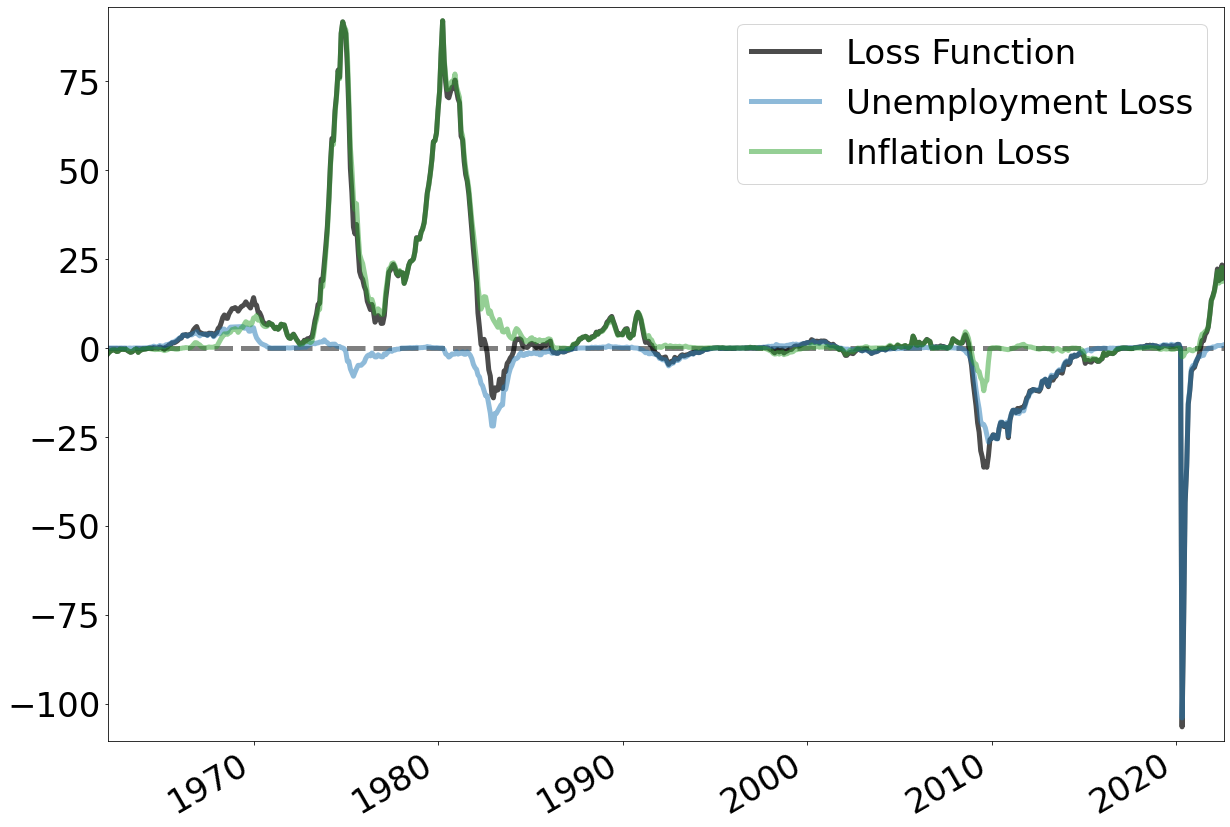

In [7]:
fig,ax = plt.subplots(figsize=(20,15))
ax.axhline(0, linestyle = "--", linewidth = 5, color = "k", alpha = .5)
annual_rate.dropna()[["Loss Function"]].plot.line(ax = ax, linewidth = 5, color = "k", alpha =.7)
annual_rate.dropna()[["Unemployment Loss"]].mul(-1).plot.line(ax = ax, linewidth = 5, color = ["C0"], alpha = .5)
annual_rate.dropna()[["Inflation Loss"]].plot.line(ax = ax, linewidth = 5, color = ["C2"], alpha = .5) 
ax.set_xlabel("")


In [8]:
x = annual_rate["10 Year UST"].diff(12)
y = annual_rate["Currency in Circulation"].diff(12).shift(-12)
corr_data = pd.DataFrame([x,y]).T.dropna().loc[:"2008-09"]
corr_data.corr()

,10 Year UST,Currency in Circulation
10 Year UST,1.000000,-0.342489
Currency in Circulation,-0.342489,1.000000


<AxesSubplot:xlabel='10 Year UST', ylabel='Currency in Circulation'>

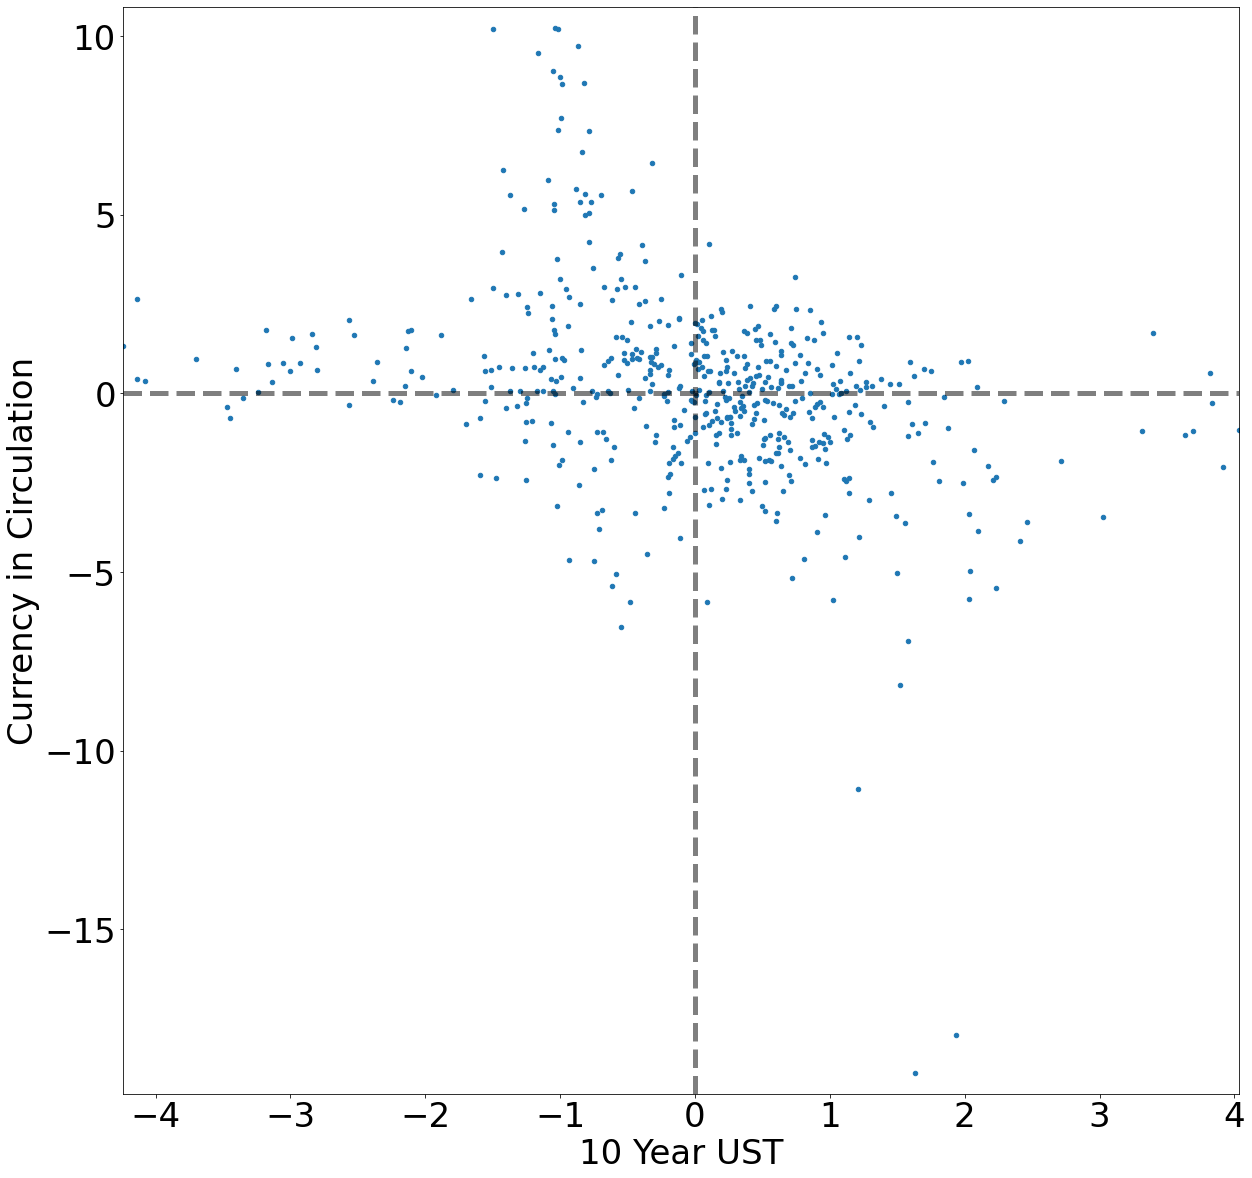

In [9]:
import pingouin
fig,ax = plt.subplots(figsize=(20,20))
ax.axhline(0, linestyle = "--", linewidth = 5, color = "k", alpha = .5)
ax.axvline(0, linestyle = "--", linewidth = 5, color = "k", alpha = .5)

corr_data.plot.scatter(x = "10 Year UST", y = "Currency in Circulation", ax = ax)
# intersect = set(x).intersection(y)
# pd.DataFrame(np.corrcoef(x, y), columns = ["Currency in Circulation", "10 Year UST"])

,Currency in Circulation,Loss Function
Currency in Circulation,1.000000,-0.124557
Loss Function,-0.124557,1.000000


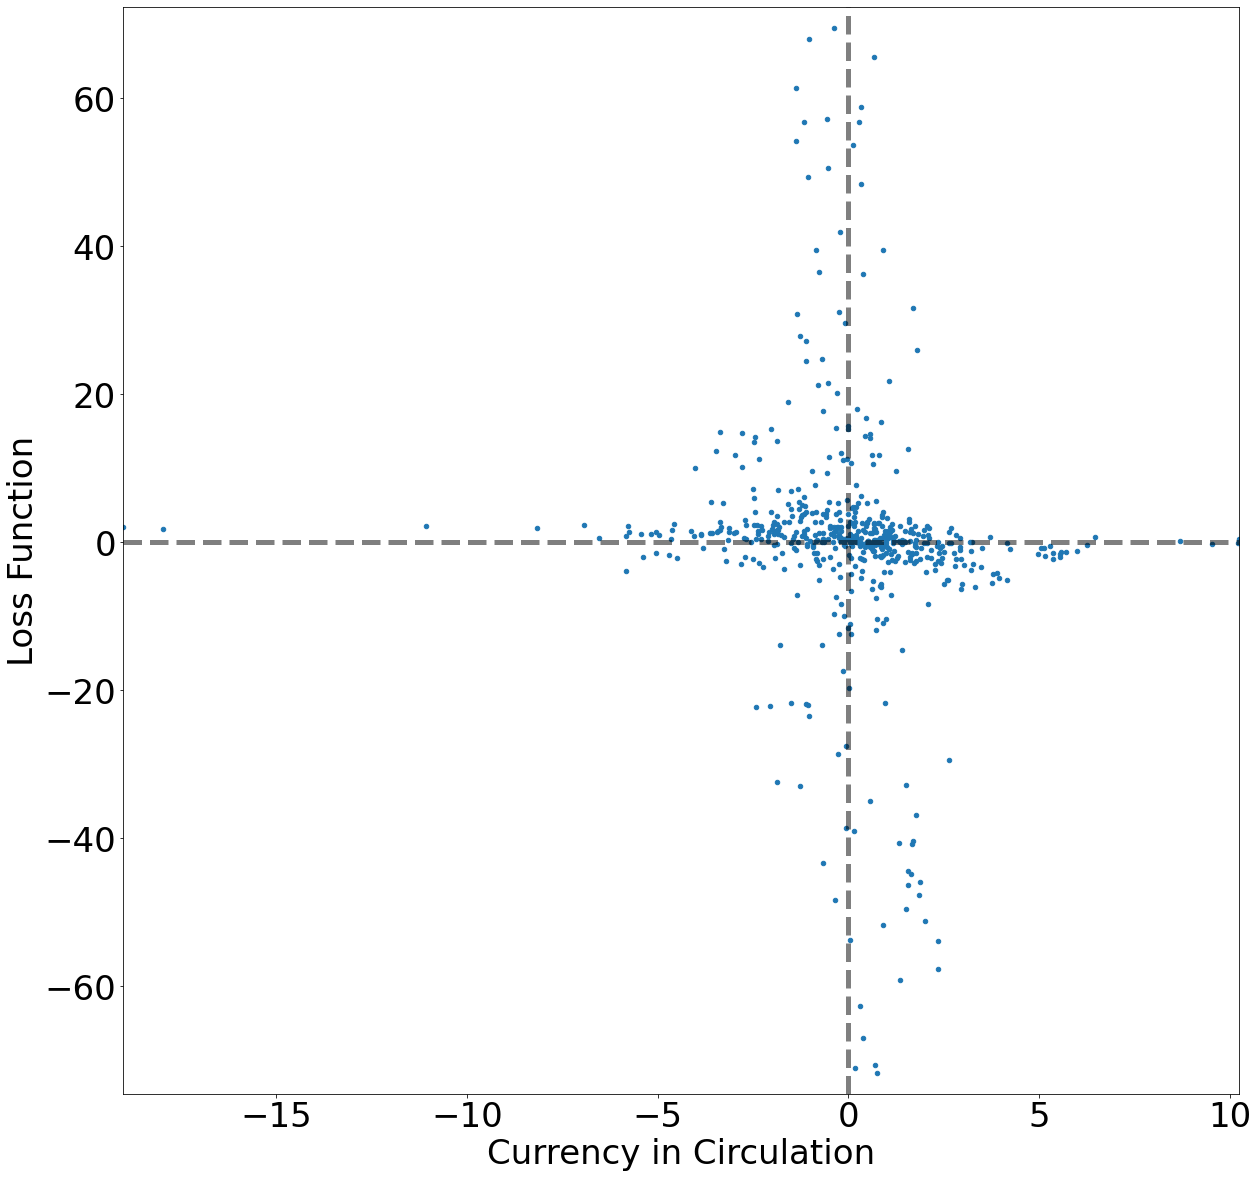

In [10]:
x = annual_rate["Currency in Circulation"].diff(12)
y = annual_rate["Loss Function"].diff(12).shift(12)
corr_data = pd.DataFrame([x,y]).T.dropna().loc[:"2008-09"]
corr_data.corr()
fig,ax = plt.subplots(figsize=(20,20))
ax.axhline(0, linestyle = "--", linewidth = 5, color = "k", alpha = .5)
ax.axvline(0, linestyle = "--", linewidth = 5, color = "k", alpha = .5)
corr_data.plot.scatter(x = "Currency in Circulation", y = "Loss Function", ax = ax)
corr_data.corr()
# intersect = set(x).intersection(y)
# pd.DataFrame(np.corrcoef(x, y), columns = ["Currency in Circulation", "10 Year UST"])